In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Simulating pore with varying tether length and sequences

In [2]:
'''
Initialise functions for plotting and processing data
'''

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video


#centre of barrel
xc = (60.57 + 39.43)/2
yc = 50
zc = 69.96
lengthToNm = 0.8518 
timeTons   = 3.03e-3
barHeight = 61.05

connShift = [0, 186, 372, 558]


def getPoreNt(teth_len, numConn = 0):
    scaf_start = 0 + connShift[numConn]
    scaf_end   = 593-40 + teth_len*2 + connShift[numConn]
    return np.arange(teth_len + scaf_start, scaf_end - teth_len)
    
    
def getTopNt(teth_len, numConn = 0):
    #print(connShift[numConn])
    return teth_len + connShift[numConn]
    
def getMidNt(teth_len, numConn = 0):
    return teth_len + 44 + connShift[numConn]

def getBotNt(teth_len, numConn = 0):
    return teth_len + 89 + connShift[numConn]
    
    
def RMS(x, y, z):
    #takes a vector (e.g. velocity) broken into components x,y,z and returns the RMS value
    return np.sqrt(x**2 + y**2 + z**2)


def getPosition(data, nt, pos, vel, rot):
    #takes data and returns position in nm relative to centre of barrel
    xpos = data[:,0 + 3*nt*(pos + vel + rot)] 
    ypos = data[:,1 + 3*nt*(pos + vel + rot)] 
    zpos = data[:,2 + 3*nt*(pos + vel + rot)] 
    xpos = (xpos - xc)*lengthToNm
    ypos = (ypos - yc)*lengthToNm
    zpos = (zpos - zc)*lengthToNm
    return [xpos, ypos, zpos]

def getVelocity(data, nt, pos, vel, rot):
    #takes data and returns velocity in nm/ns relative to centre of barrel
    xvel = data[:,3 + 3*nt*(pos + vel + rot)] 
    yvel = data[:,4 + 3*nt*(pos + vel + rot)] 
    zvel = data[:,5 + 3*nt*(pos + vel + rot)] 
    xvel = xvel*lengthToNm/timeTons
    yvel = yvel*lengthToNm/timeTons
    zvel = zvel*lengthToNm/timeTons
    return [xvel, yvel, zvel]


def getAngularV(data, nt, pos, vel, rot):
    #takes data and returns angular velocity in 1/ns relative to centre of barrel
    xrot = data[:,6 + 3*nt*(pos + vel + rot)] 
    yrot = data[:,7 + 3*nt*(pos + vel + rot)] 
    zrot = data[:,8 + 3*nt*(pos + vel + rot)] 
    xrot = xrot/timeTons/np.pi*180
    yrot = yrot/timeTons/np.pi*180
    zrot = zrot/timeTons/np.pi*180
    return [xrot, yrot, zrot]


def takeMean(Vec):
    #given a list takes the mean along each coordinate
    for i in range(len(Vec)):
        Vec[i] = np.mean(Vec[i],1)
    return Vec


def takeMin(Vec):
    for i in range(len(Vec)):
        Vec[i] = np.array(Vec[i]).min(1)
    return Vec   
    
def takeMax(Vec):
    for i in range(len(Vec)):
        Vec[i] = np.array(Vec[i]).max(1)
    return Vec

def cartToCyl(x,y,z):
    #converts Cartesian coords to cylindrical coordinates in degrees
    r     = np.sqrt(x**2 + y**2)
    theta = np.arctan2(posV[1], posV[0])/np.pi*180
    return [r, theta, z]


def plotPositionHist(posV, pType = 'z', title = None, vline = None, saveName = None):
    '''
    plots the histogram of a spatial or angular coordinate
    posV is the position vector
    pType = 'x', 'y', 'z', 't' (theta), 'r' (radial)
    '''   
    plt.figure()
    plt.xlabel('Position (nm)')
    if pType == 'x':
        pos = posV[0]
        plt.title('Histogram of location of pore - x-position')
    elif pType == 'y':
        pos = posV[1]
        plt.title('Histogram of location of pore - y-position')        
    elif pType == 'z':
        pos = posV[2]
        plt.title('Histogram of location of pore - z-position')
    elif pType == 'r':
        pos = np.sqrt(posV[0]**2 + posV[1]**2)
        plt.title('Histogram of location of pore - r-position')
        plt.xlabel('Radial distance from centre of pore (nm)')
    elif pType == 't':
        pos = np.arctan2(posV[1], posV[0])/np.pi*180     
        plt.title('Histogram of location of pore - angular distance of pore in barrel')
        plt.xlabel('Angular distance of pore in barrel (degrees)')

    if title is not None:
        plt.title(title)
        
    plt.hist(pos, density = True, bins = int(np.sqrt(len(pos))))
    
    xmin, xmax, ymin, ymax = plt.axis()    
    if vline is not None:
        plt.vlines(vline, 0, ymax, 'r')
    plt.ylabel('Probability density')
    if saveName is not None:
        plt.savefig(saveName + '.png', bbox_inches='tight')        
    plt.show()

    
    
def plotRMSHist(Vec, pType = 'vel', saveName = None):
    '''
    plots the histogram of a spatial or angular coordinate
    Vec is a vector: either position, velocity or angular velocity
    pType = 'pos', 'vel', 'rot'
    '''       
    RMSVec = RMS(Vec[0], Vec[1], Vec[2])
    plt.figure()
    plt.hist(RMSVec, density = True)
    plt.ylabel('Probability density')

    if pType == 'pos':
        plt.xlabel('Average root mean squared position (nm)')
        plt.title('Histogram of average root mean squared position')
    elif pType == 'vel':
        plt.xlabel('Average root mean squared velocity (nm/ns)')
        plt.title('Histogram of average root mean squared velocity')
    elif pType == 'rot':
        plt.xlabel('Average root mean squared angular velocity (degrees/ns)')
        plt.title('Histogram of average root mean squared angular velocity')
    if saveName is not None:
        plt.savefig(saveName + '.png', bbox_inches='tight')    
    plt.show()



def plotMeanStdPair(xval, Means, Stds, ylabel1 = '', ylabel2 = '', xlabel = 'Tether length (bp)', title = '', saveName = None):
    plt.figure()
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1, color='b')
    ax1.plot(xval, Means, 'bo')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel(ylabel2, color='r')  
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.plot(xval, Stds, 'rx')
    plt.title(title)
    fig.tight_layout() 
    if saveName is not None:
        plt.savefig(saveName + '.png', bbox_inches='tight') 
    plt.show()
        
    
#plot mean-standard deviation pair with error bars
def plotMeanStdEB(xval, Means, Stds, ylabel = '', xlabel = 'Tether length (bp)', title = '', legend = [], hline = None, vline = None):
    plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    shapes = ['o', '^', 'D', '*', 's', 'p', 'h']
    if np.ndim(Means) == 1:
        plt.errorbar(xval, Means, Stds, fmt='bo:', label = legend[0])
    else:
        for i in range(np.shape(Means)[1]):
            plt.errorbar(xval, Means[:,i], Stds[:,i], fmt=shapes[i] + ':', label = legend[i])
    
    if hline is not None:
        plt.hlines(hline, xval[0], xval[-1], linestyles='dashed')
    
    xmin, xmax, ymin, ymax = plt.axis()
    if vline is not None:
        plt.vlines(vline, ymin, ymax, linestyles='dashed')

    plt.title(title)
    plt.legend()
    plt.show()    

    
#plot mean-standard deviation pair with error bars inverse
def plotMeanStdEBInverse(xval, Means, Stds, ylabel = '', xlabel = 'Tether length (bp)', title = '', legend = [], hline = None, vline = None):
    plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    shapes = ['o', '^', 'D', '*', 's', 'p', 'h']
    if np.ndim(Means) == 1:
        plt.errorbar(xval, Means, Stds, fmt='bo:', label = legend[0])
    else:
        for i in range(np.shape(Means)[0]):
            plt.errorbar(legend, Means[i,:], Stds[i,:], fmt=shapes[i] + ':', label = xval[i])
    
    if hline is not None:
        plt.hlines(hline, legend[0], legend[-1], linestyles='dashed')
    
    xmin, xmax, ymin, ymax = plt.axis()
    if vline is not None:
        plt.vlines(vline, ymin, ymax, linestyles='dashed')

    plt.title(title)
    plt.legend()
    plt.show()        

In [18]:
'''
Loop over data
'''

N = 3
M = 20

poreEnd = 43
topEnd  = 9
s = -100


ave_z   = np.zeros([N,M])
ave_r   = np.zeros([N,M])
ave_th  = np.zeros([N,M])
std_z   = np.zeros([N,M])
std_r   = np.zeros([N,M])
std_th  = np.zeros([N,M])

ave_top_z   = np.zeros([N,M])
ave_top_r   = np.zeros([N,M])
ave_top_th  = np.zeros([N,M])
std_top_z   = np.zeros([N,M])
std_top_r   = np.zeros([N,M])
std_top_th  = np.zeros([N,M])

ave_mid_z   = np.zeros([N,M])
ave_mid_r   = np.zeros([N,M])
ave_mid_th  = np.zeros([N,M])
std_mid_z   = np.zeros([N,M])
std_mid_r   = np.zeros([N,M])
std_mid_th  = np.zeros([N,M])

ave_bot_z   = np.zeros([N,M])
ave_bot_r   = np.zeros([N,M])
ave_bot_th  = np.zeros([N,M])
std_bot_z   = np.zeros([N,M])
std_bot_r   = np.zeros([N,M])
std_bot_th  = np.zeros([N,M])

ave_min_z   = np.zeros([N,M])
ave_min_r   = np.zeros([N,M])
ave_min_th  = np.zeros([N,M])
std_min_z   = np.zeros([N,M])
std_min_r   = np.zeros([N,M])
std_min_th  = np.zeros([N,M])

ave_max_z   = np.zeros([N,M])
ave_max_r   = np.zeros([N,M])
ave_max_th  = np.zeros([N,M])
std_max_z   = np.zeros([N,M])
std_max_r   = np.zeros([N,M])
std_max_th  = np.zeros([N,M])


ave_bonds   = np.zeros([N,M])
std_bonds   = np.zeros([N,M])
max_bonds   = np.zeros([N,M])
min_bonds   = np.zeros([N,M])
end_bonds   = np.zeros([N,M])

FracOut = np.zeros([N, M])
FracTop = np.zeros([N, M])


minBonds = 0 #[495, 495 + 60, 495 + 11*15, 495 + 84*2, 495 + 84*2] #84*2 is the cinch length

teth_len = 120
conns = [1,2,3]

idxs = [4,7,11]

for c in range(N):
    for m in range(M):
        
        print('Now processing : poreConnectors' + str(idxs[c]) + ', seed: ' + str(m))
        data = np.genfromtxt('poreConnectors' + str(idxs[c]) + '/outposMD' + str(m) + '.dat')

        #nucleotide to track
        nt = getPoreNt(teth_len, numConn = conns[c])

        #Get mean positions
        posV = takeMean(getPosition(data, nt, 1, 0, 0))

        #if pore is in opposite orientation
        if np.mean(posV[2]) > 0:
            zsign = 1
        else:
            zsign = 1

        ave_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_z[c,m]   = np.std(posV[2][s:-1])
        std_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))

        #Get top positions
        posV = getPosition(data, getTopNt(teth_len, numConn = conns[c]), 1, 0, 0)
        ave_top_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_top_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_top_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_top_z[c,m]   = np.std(posV[2][s:-1])
        std_top_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_top_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))

        #Get middle positions
        posV = getPosition(data, getMidNt(teth_len, numConn = conns[c]), 1, 0, 0)              
        ave_mid_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_mid_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_mid_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_mid_z[c,m]   = np.std(posV[2][s:-1])
        std_mid_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_mid_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))

        #Get bottom positions
        posV = getPosition(data, getBotNt(teth_len, numConn = conns[c]), 1, 0, 0)              
        ave_bot_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_bot_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_bot_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_bot_z[c,m]   = np.std(posV[2][s:-1])
        std_bot_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_bot_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))


        #Get minimum positions
        posV = takeMin(getPosition(data, nt, 1, 0, 0))  
        posV1 = posV.copy()
        ave_min_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_min_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_min_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_min_z[c,m]   = np.std(posV[2][s:-1])
        std_min_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_min_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        
        #Get maximum positions
        posV = takeMax(getPosition(data, nt, 1, 0, 0))            
        ave_max_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_max_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_max_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_max_z[c,m]   = np.std(posV[2][s:-1])
        std_max_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_max_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))

        #fraction of time outside the pore
        FracOut[c,m] = sum(((posV1[2][s:-1][i] < -poreEnd) | (posV[2][s:-1][i] >  topEnd))  for i in range(len(posV[2][s:-1])))/len(posV[2][s:-1])      
        FracTop[c,m] = sum(((posV[2][s:-1][i] >  poreEnd)  | (posV1[2][s:-1][i] < -topEnd))  for i in range(len(posV[2][s:-1])))/len(posV[2][s:-1])

        #number of bonds
        bonds = np.genfromtxt('poreConnectors' + str(idxs[c]) + '/numbondsMD' + str(m) + '.txt')    
        bonds = bonds - minBonds
        bonds = bonds.clip(min=0)
        ave_bonds[c,m]   = np.mean(bonds)
        std_bonds[c,m]   = np.std(bonds)
        max_bonds[c,m]   = np.max(bonds)
        min_bonds[c,m]   = np.min(bonds)        
        end_bonds[c,m]   = bonds[-1]
    

        
print('Finished processing')

Now processing : poreConnectors4, seed: 0
Now processing : poreConnectors4, seed: 1
Now processing : poreConnectors4, seed: 2
Now processing : poreConnectors4, seed: 3
Now processing : poreConnectors4, seed: 4
Now processing : poreConnectors4, seed: 5
Now processing : poreConnectors4, seed: 6
Now processing : poreConnectors4, seed: 7
Now processing : poreConnectors4, seed: 8
Now processing : poreConnectors4, seed: 9
Now processing : poreConnectors4, seed: 10
Now processing : poreConnectors4, seed: 11
Now processing : poreConnectors4, seed: 12
Now processing : poreConnectors4, seed: 13
Now processing : poreConnectors4, seed: 14
Now processing : poreConnectors4, seed: 15
Now processing : poreConnectors4, seed: 16
Now processing : poreConnectors4, seed: 17
Now processing : poreConnectors4, seed: 18
Now processing : poreConnectors4, seed: 19
Now processing : poreConnectors7, seed: 0
Now processing : poreConnectors7, seed: 1
Now processing : poreConnectors7, seed: 2
Now processing : poreCon

Text(0, 0.5, 'Number of bonds')

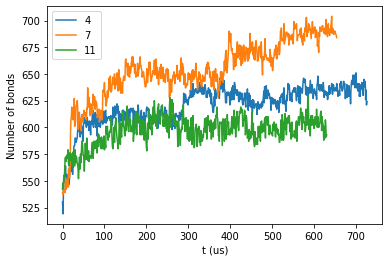

In [20]:
bonds = []
plt.figure()
for i in range(3):
    bonds.append(np.genfromtxt('poreConnectors' + str(idxs[i]) + '/numbondsMD6.txt'))
    plt.plot(np.arange(len(bonds[i])), bonds[i])
plt.legend(idxs)
plt.xlabel('t (us)')
plt.ylabel('Number of bonds')

In [21]:
len(bonds[i])

631

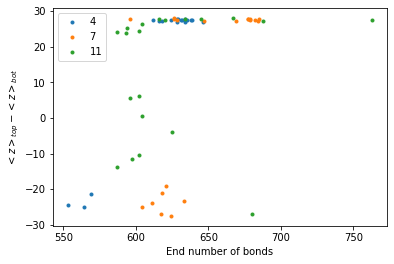

In [107]:
plt.figure()
plt.plot(end_bonds.transpose(), ave_top_z.transpose() - ave_bot_z.transpose(), '.')
plt.legend(idxs)
plt.ylabel(r'$<z>_{top} - <z>_{bot}$')
plt.xlabel('End number of bonds', title = '# ')
plt.show()

In [81]:
upinc = ((ave_top_z.transpose() - ave_bot_z.transpose() > 10) & (end_bonds.transpose() > np.array([584, 647, 731]))).transpose()
print(np.sum(upinc, 1))

downinc = ((ave_top_z.transpose() - ave_bot_z.transpose() < 10) & (end_bonds.transpose() > np.array([574, 637, 721]))).transpose()
print(np.sum(downinc, 1))

[17  8  1]
[0 0 0]


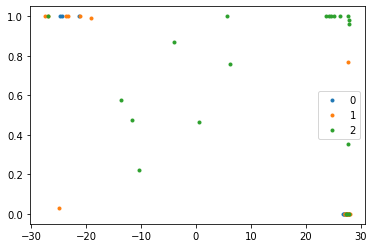

In [17]:
plt.figure()
plt.plot(ave_top_z.transpose() - ave_bot_z.transpose(), FracOut.transpose(), '.')
plt.legend([0,1,2,3])
plt.show()

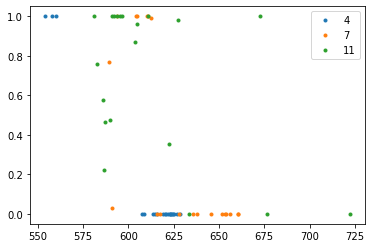

In [14]:
plt.plot(ave_bonds.transpose(), FracOut.transpose(), '.')
plt.legend(idxs)
plt.show()

In [116]:
# Facing upwards

inc = (ave_top_z.transpose() - ave_bot_z.transpose() < 0).transpose()

def mymean(x, i):
    return (np.sum(x*inc, 1)/np.sum(inc, 1))[i]

for i in range(3):
    print(mymean(FracOut,i), ',', mymean(ave_top_z,i), ',',  mymean(std_top_z,i), ',', mymean(ave_top_r,i),',', mymean(std_top_r,i),',',mymean(ave_mid_z,i),',', mymean(std_mid_z,i),',',mymean(ave_mid_r,i),',',mymean(std_mid_r,i),',',mymean(ave_bot_z,i),',', mymean(std_bot_z,i),',',mymean(ave_bot_r,i),',',mymean(std_bot_r,i),',',mymean(ave_min_z,i),',',mymean(std_min_z,i),',', mymean(ave_min_r,i),',',mymean(std_min_r,i),',',mymean(ave_max_z,i),',',mymean(std_max_z,i),',',mymean(ave_max_r,i),',',mymean(std_max_r,i),',',mymean(ave_bonds,i),',',mymean(std_bonds,i),',',np.min(min_bonds[:,inc[i]]),',',np.max(max_bonds[:,inc[i]]), ',', np.sum(inc[i]))

1.0 , 4.720915926085342 , 2.8401846902673324 , 3.828707706793928 , 1.6423323447096372 , 17.070131370633796 , 2.9798221518085755 , 6.9709335192126645 , 2.579418827301683 , 28.22706009273357 , 4.309772083689506 , 13.513497802617728 , 5.238477817909307 , 2.601410105626281 , 2.833515953389091 , 11.43967006278787 , 5.273569824483373 , 30.103974232139432 , 3.616398582257936 , 12.355245478138015 , 5.940864385182081 , 557.3319908742877 , 8.763799207135277 , 522.0 , 709.0 , 3
0.8600288600288601 , -7.323396509680933 , 1.2019140096101424 , 3.1181258973154398 , 1.098824234157809 , 4.14871691720942 , 1.140993336524676 , 4.520656036941455 , 1.3401428974773404 , 16.475717692757527 , 1.7689852431653068 , 8.942736549224987 , 2.373364117803191 , -10.78921724577462 , 1.237705388954627 , 9.751732807767246 , 2.0515637180511592 , 18.129439219271262 , 1.2924238969592459 , 10.06250526076366 , 2.1284832104310945 , 603.9929855833956 , 19.000793423445845 , 518.0 , 774.0 , 7
0.6282828282828283 , -19.2275856375295

In [115]:
# Facing downwards, at completion

inc = ((ave_top_z.transpose() - ave_bot_z.transpose() > 0) & (end_bonds.transpose() > np.array([584, 647, 731]))).transpose()

def mymean(x, i):
    return (np.sum(x*inc, 1)/np.sum(inc, 1))[i]

for i in range(3):
    print(mymean(FracOut,i), ',', mymean(ave_top_z,i), ',',  mymean(std_top_z,i), ',', mymean(ave_top_r,i),',', mymean(std_top_r,i),',',mymean(ave_mid_z,i),',', mymean(std_mid_z,i),',',mymean(ave_mid_r,i),',',mymean(std_mid_r,i),',',mymean(ave_bot_z,i),',', mymean(std_bot_z,i),',',mymean(ave_bot_r,i),',',mymean(std_bot_r,i),',',mymean(ave_min_z,i),',',mymean(std_min_z,i),',', mymean(ave_min_r,i),',',mymean(std_min_r,i),',',mymean(ave_max_z,i),',',mymean(std_max_z,i),',',mymean(ave_max_r,i),',',mymean(std_max_r,i),',',mymean(ave_bonds,i),',',mymean(std_bonds,i),',',np.min(min_bonds[:,inc[i]]),',',np.max(max_bonds[:,inc[i]]), ',', np.sum(inc[i]))

0.0 , -0.8355702512392382 , 2.3244700928742694 , 3.382022890932565 , 1.4515037690611923 , -14.867847865411598 , 2.299303817728583 , 2.262082079154334 , 1.0926811800525873 , -28.24755261263958 , 2.4526362841952665 , 4.487237376651328 , 1.7313878488334022 , -29.417792663271655 , 2.285946920804774 , 7.413425183912873 , 1.28093381943739 , 0.62752127639408 , 2.3182281279184074 , 8.174669616872473 , 1.3586173617672157 , 620.112469693508 , 17.90180159591483 , 510.0 , 774.0 , 17
0.0 , -9.731029504236517 , 0.8636035773391435 , 3.487793829236166 , 1.1407988263622728 , -23.84679732170862 , 0.801847167753757 , 2.484496105402835 , 1.0589139987093787 , -37.28804839635604 , 1.0492372086600423 , 3.9567334958756653 , 1.8210001803934914 , -38.1526547758077 , 0.8878205978477886 , 7.02133545106417 , 1.2519954291556983 , -7.989000512921836 , 0.8961608171585104 , 7.975818296616035 , 1.1950566223356387 , 652.5068615890563 , 28.98264422101271 , 516.0 , 704.0 , 8
0.0 , -9.055668205608628 , 0.9729988754914028 ,

In [118]:
# All simulations
for i in range(3):
    print(np.mean(FracOut[i]), ',', np.mean(ave_top_z[i]), ',',  np.mean(std_top_z[i]), ',', np.mean(ave_top_r[i]),',', np.mean(std_top_r[i]),',',np.mean(ave_mid_z[i]),',', np.mean(std_mid_z[i]),',',np.mean(ave_mid_r[i]),',',np.mean(std_mid_r[i]),',',np.mean(ave_bot_z[i]),',', np.mean(std_bot_z[i]),',',np.mean(ave_bot_r[i]),',',np.mean(std_bot_r[i]),',',np.mean(ave_min_z[i]),',',np.mean(std_min_z[i]),',', np.mean(ave_min_r[i]),',',np.mean(std_min_r[i]),',',np.mean(ave_max_z[i]),',',np.mean(std_max_z[i]),',',np.mean(ave_max_r[i]),',',np.mean(std_max_r[i]),',',np.mean(ave_bonds[i]),',',np.mean(std_bonds[i]),',',np.min(min_bonds[i]),',',np.max(max_bonds[i]))

0.15 , -0.0020973246405514012 , 2.4018272824832296 , 3.4490256133117705 , 1.4801280554084588 , -10.077150980004788 , 2.401381567840582 , 2.9684097951630832 , 1.3156918271399518 , -19.776360706833607 , 2.731206654119402 , 5.841176440546287 , 2.2574513441947883 , -24.614912247936964 , 2.3680822756924216 , 8.017361915744123 , 1.8798292201942874 , 5.048989219755883 , 2.5129536960693364 , 8.801755996062305 , 2.045954415279445 , 610.6953978706249 , 16.531101237597895 , 510.0 , 657.0
0.3393939393939394 , -9.535229853495434 , 1.0100279316037517 , 3.525543680944513 , 1.137410731109973 , -14.728361993152152 , 0.9554353075985755 , 3.173091444408585 , 1.162406460440827 , -19.14771136356451 , 1.3440913863042545 , 5.757962255154849 , 2.0035912948722925 , -29.25931123966464 , 1.0430894508887667 , 8.095164623438937 , 1.536044203390118 , 0.46492376097313615 , 1.0609410998117137 , 8.690275840858394 , 1.5252362638844794 , 626.7041384923743 , 23.20601907246478 , 516.0 , 704.0
0.6828282828282828 , -21.8781

In [10]:
bondTS = []
av_bTS = []
mx_bTS = []
mn_bTS = []
sd_bTS = []

simTimes = np.zeros((N,M))


endTime = [700, 650, 550]

for i in range(N):
    bonds = []
    for j in range(M):
        bonds.append(np.genfromtxt('poreConnectors' + str(idxs[i]) + '/numbondsMD' + str(j) + '.txt'))
        #if len(bonds[j]) < endTime[i]:
        #    endTime[i] = len(bonds[j])
        simTimes[i,j] = len(bonds[j])
    bondTS.append(bonds)

    

for i in range(N):
    bonds = []
    mxbnd = []
    mnbnd = []
    sdbnd = []
    
    for t in range(endTime[i]):
        tmp = []
        for j in range(M):
            if t < simTimes[i,j]:
                tmp.append(bondTS[i][j][t])
        if len(tmp) > 0:
            bonds.append(np.mean(tmp))
            mxbnd.append(np.max(tmp))
            mnbnd.append(np.min(tmp))
            sdbnd.append(np.std(tmp))        
        else:
            bonds.append(np.nan)
            mxbnd.append(np.nan)
            mnbnd.append(np.nan)
            sdbnd.append(np.nan)
            
    av_bTS.append(bonds)
    mx_bTS.append(mxbnd)
    mn_bTS.append(mnbnd)
    sd_bTS.append(sdbnd)
    

Text(0, 0.5, 'Average number of bonds')

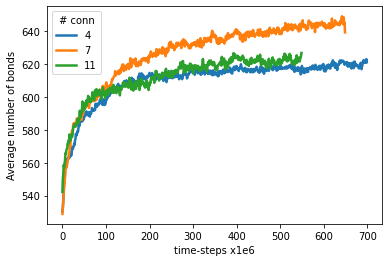

In [120]:
bonds = []
col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.figure()
for i in range(3):
    time = np.arange(endTime[i])
    plt.plot(time, av_bTS[i], color = col[i], lw = 2.5, label = str(idxs[i]))
plt.legend(title = '# conn')
plt.xlabel('time-steps x1e6')
plt.ylabel('Average number of bonds')

Text(0, 0.5, 'Average number of bonds')

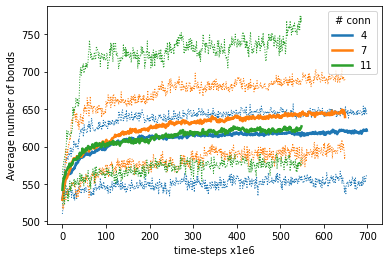

In [113]:
initTime = 0

bonds = []
col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
plt.figure()
for i in range(3):
    time = np.arange(endTime[i])
    time += initTime
    plt.plot(time, av_bTS[i], color = col[i], lw = 2.5, label = str(idxs[i]))
    plt.plot(time, mx_bTS[i], ':', color = col[i], lw = 1, label = None)
    plt.plot(time, mn_bTS[i], ':', color = col[i], lw = 1, label = None)
    
    #plt.fill_between(time, mn_bTS[i], mx_bTS[i])
plt.legend(title = '# conn')
plt.xlabel('time-steps x1e6')
plt.ylabel('Average number of bonds')



In [55]:
simTimes

array([[555., 712., 729., 720., 763., 734., 727., 726., 733., 721., 725.,
        758., 773., 726., 716., 725., 731., 724., 735., 719.],
       [672., 653., 643., 647., 680., 639., 655., 649., 657., 658., 657.,
        657., 660., 655., 646., 680., 650., 650., 649., 668.],
       [609., 627., 630., 627., 588., 613., 631., 626., 601., 642., 581.,
        569., 570., 628., 633., 641., 632., 657., 626., 552.]])

ValueError: shape mismatch: objects cannot be broadcast to a single shape

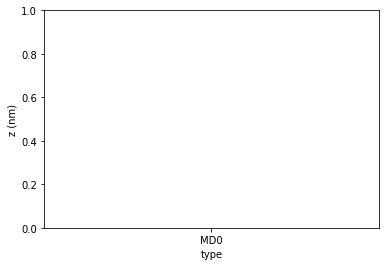

In [24]:
'''
Comparison between the different pores
'''

teth_lens = [teth_len]
seqNames = ['MD0', 'MD1', 'MD2', 'MD3']
types = ['top', 'mid', 'bot', 'mean', 'min']
ave_zs    = np.array([ave_top_z[:], ave_mid_z[:], ave_bot_z[:], ave_z[:], ave_min_z[:]])
std_zs    = np.array([std_top_z[:], std_mid_z[:], std_bot_z[:], std_z[:], std_min_z[:]])
ave_rs    = np.array([ave_top_r[:], ave_mid_r[:], ave_bot_r[:], ave_r[:], ave_min_r[:]])
std_rs    = np.array([std_top_r[:], std_mid_r[:], std_bot_r[:], std_r[:], std_min_r[:]])

plotMeanStdEBInverse(types, ave_zs, std_zs, ylabel = 'z (nm)', title = 'Vertical position in barrel', legend = seqNames, xlabel = 'type', hline = -32)
plotMeanStdEBInverse(types, ave_rs, std_rs, ylabel = 'r (nm)', title = 'Radial position in barrel', legend = seqNames, xlabel = 'type')
plotMeanStdEBInverse(types, std_zs, std_zs*0, ylabel = 'std(z) (nm)', title = 'Std Vertical position in barrel', legend = seqNames, xlabel = 'type')
plotMeanStdEBInverse(types, std_rs, std_rs*0, ylabel = 'std(r) (nm)', title = 'Std Radial position in barrel', legend = seqNames, xlabel = 'type')

plt.figure()
plt.plot(seqNames, FracOut, 'o:')
plt.ylabel('Outside barrel (%)')
plt.title('Fraction of time outside barrel')
plt.show()
#plotMeanStdEBInverse(teth_lens, 100*FracOut, 0*FracOut, ylabel = 'Outside barrel (%)', title = 'Fraction of time outside barrel', legend = seqNames, xlabel = 'type')
#plotMeanStdEBInverse(teth_lens, ave_bonds, std_bonds, ylabel = 'Number of tether bonds', title = 'Bonding on tether', legend = seqNames, xlabel = 'type')

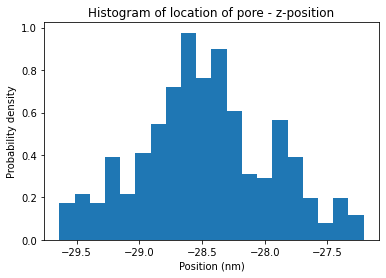

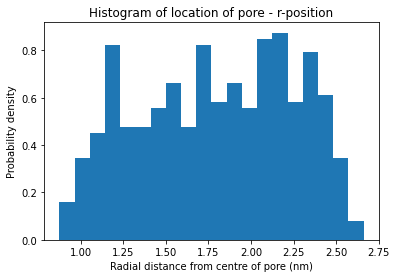

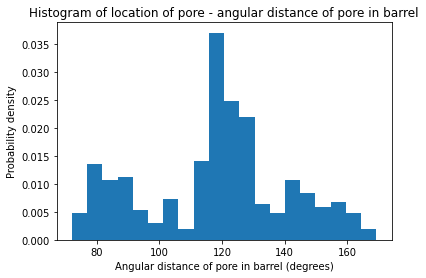

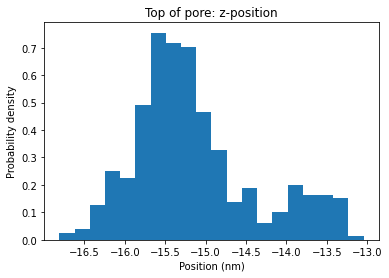

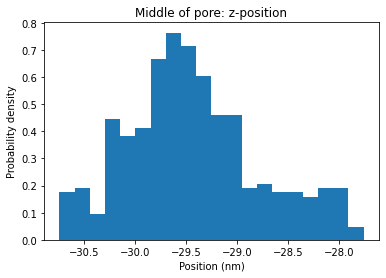

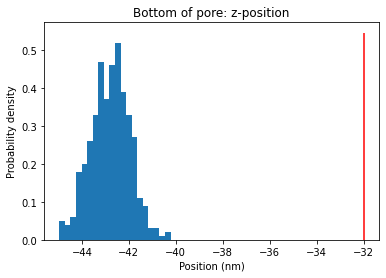

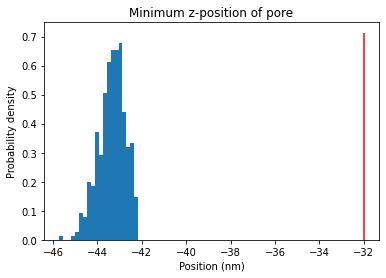

In [21]:
'''
Import data for tether length 45
'''

folder = 'MD1/'
data = np.genfromtxt(folder + '/jointpos.dat')

teth_len = 120

#nucleotide to track
nt = getPoreNt(teth_len,1)

#Get positions
posV = takeMean(getPosition(data, nt, 1, 0, 0))

folder = folder + '/pics/'

#Plot histograms
plotPositionHist(posV, 'z', saveName = folder + 'zhist')
plotPositionHist(posV, 'r', saveName = folder + 'zhist')
plotPositionHist(posV, 't', saveName = folder + 'thethist')

#bottom, middle and top of pore
plotPositionHist(getPosition(data, getTopNt(teth_len,1), 1, 0, 0), 'z', title = 'Top of pore: z-position', saveName = folder + 'top_zhist')
plotPositionHist(getPosition(data, getMidNt(teth_len,1), 1, 0, 0), 'z', title = 'Middle of pore: z-position', saveName = folder + 'mid_zhist')
plotPositionHist(getPosition(data, getBotNt(teth_len,1), 1, 0, 0), 'z', title = 'Bottom of pore: z-position', vline = -32, saveName = folder + 'bot_zhist')
plotPositionHist(takeMin(getPosition(data, nt, 1, 0, 0)), 'z', title = 'Minimum z-position of pore', vline = -32, saveName = folder + 'min_zhist')

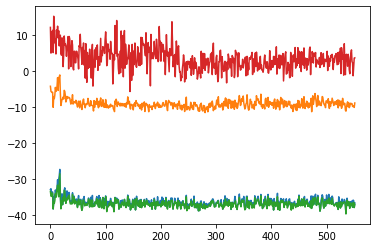

In [19]:
data = np.genfromtxt('poreConnectors11/outposMD19.dat')
np.shape(data)

nt = getPoreNt(teth_len, numConn = 2)
posBot = getPosition(data, getBotNt(teth_len, numConn = 3), 1, 0, 0)
posTop = getPosition(data, getTopNt(teth_len, numConn = 3), 1, 0, 0)
posMin = takeMin(getPosition(data, nt, 1, 0, 0))
posMax = takeMax(getPosition(data, nt, 1, 0, 0))


plt.figure()
plt.plot(posBot[2])
plt.plot(posTop[2])
plt.plot(posMin[2])
plt.plot(posMax[2])
plt.show()

In [21]:
end_bonds

array([[638., 634., 634., 631., 553., 629., 624., 634., 616., 612., 646.,
        569., 564., 634., 628., 632., 618., 628., 639., 635.],
       [596., 624., 685., 682., 633., 626., 684., 679., 677., 626., 647.,
        617., 628., 604., 621., 611., 679., 669., 677., 618.],
       [616., 602., 604., 597., 667., 620., 593., 587., 634., 596., 645.,
        688., 680., 604., 602., 602., 594., 587., 625., 763.]])